## Stock Market Forecasting

ARIMA is an acronym for “autoregressive integrated moving average.” It’s a model used in statistics and econometrics to measure events that happen over a period of time. The model is used to understand past data or predict future data in a series. It’s used when a metric is recorded in regular intervals, from fractions of a second to daily, weekly or monthly periods. 

In this model, we are using ARIMA to predict future stock prices and make informed decisions on whether to buy or sell a particular stock in order to maximise total returns and minimise risk. Over the course of the time frame, the model will rebalance the portfolio every month based on the expected change in price in the coming month.

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pandas_datareader import data as web


matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## Fetching possible values of p,d,q combinations

In [2]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

## Function to fetch prices and fit an ARIMA model on every single stock. It returns the calculated roy ratio values, and the monthly mean of the prices for each stock.
 Roy ratio =                     (predicted of next month - actual of this month) /
                 (upper limit of prediction for next month - lower limit of prediction for net month)

### Roy ratio is a term made by our team to allocate amount of money to invest in each stock. It is the predicted increase divided by the range of prediction. In case a fall is predicted, we obtain a negative roy ratio. In this case we do not invest in that stock at all.

In [3]:
def get_ratio(name):
    stock2=(web.DataReader(name, data_source='yahoo', start = '2010-06-29', end = '2022-03-18'))['Close']
    stock2=pd.DataFrame(stock2)
    stock2 = stock2.sort_values('Date')
    type(stock2)


    stock2.isnull().sum()

    stock2 = stock2.groupby('Date')['Close'].sum().reset_index()
    stock2
    stock2.head()

    stock2.Date = pd.to_datetime(stock2.Date, format='%Y%m%d', errors='ignore')
    stock2 = stock2.set_index('Date')
    stock2.index = pd.to_datetime(stock2.index)

    monthly_mean2 = stock2.Close.resample('M').mean()
    decomposition2 = sm.tsa.seasonal_decompose(monthly_mean2, model='additive')
    l_param = []
    l_param_seasonal=[]
    l_results_aic=[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(monthly_mean2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                results = mod.fit()

            
                l_param.append(param)
                l_param_seasonal.append(param_seasonal)
                l_results_aic.append(results.aic)
            except:
                continue
    minimum=l_results_aic[0]
    for i in l_results_aic[1:]:
        if i < minimum: 
            minimum = i
    i=l_results_aic.index(minimum)
    mod = sm.tsa.statespace.SARIMAX(monthly_mean2,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results2 = mod.fit()
    pred2 = results2.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False) # prediction start date
    pred_ci2 = pred2.conf_int()
    #ax = monthly_mean2['2010':].plot(label='observed')
    #pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    y_forecasted2 = pred2.predicted_mean
    y_truth2 = monthly_mean2['2017-12-31':]

    # Compute the mean square error
    mse2 = ((y_forecasted2 - y_truth2) ** 2).mean()
    actual2=pd.DataFrame(monthly_mean2['2017-12-31':'2022-03-31'])

    roy_calculation2 = pd.DataFrame(y_forecasted2)
    roy_calculation2 = pd.concat([roy_calculation2,y_truth2], axis=1).reindex(y_truth2.index)

    pred_ci2df = pd.DataFrame(pred_ci2)
    roy_calculation2 = pd.concat([roy_calculation2,pred_ci2df], axis=1).reindex(roy_calculation2.index)
    roy_calculation2['Close']=roy_calculation2['Close'].shift(1)

    roy_ratio = (roy_calculation2['predicted_mean']-roy_calculation2['Close'])/(roy_calculation2['upper Close']-roy_calculation2['lower Close'])

     # predicted_mean/range of prediction=((upper+lower)/2)/upper-lower

    return roy_ratio, pd.DataFrame(y_truth2)

### Calling the function for every stock and storing the returned values i.e. the Roy ratio and the prices

In [ ]:
stock_list=["AAPL", "CAH", "CMCSA", "DISH", "GOOG", "HSY", "JNJ", "JPM", "K", "MA", "NFLX", "UL", "WBA"]
everything = pd.DataFrame()
prices = pd.DataFrame()
for ns in stock_list:
    temp1, temp2 = get_ratio(ns)
    everything = pd.concat([everything, temp1], axis=1).reindex(temp1.index)
    prices = pd.concat([prices, temp2], axis=1).reindex(temp2.index)
    everything.rename(columns={'0': ns}, inplace=True)

everything.columns = ["AAPL", "CAH", "CMCSA", "DISH", "GOOG", "HSY", "JNJ", "JPM", "K", "MA", "NFLX", "UL", "WBA"]
prices.columns = ["AAPL", "CAH", "CMCSA", "DISH", "GOOG", "HSY", "JNJ", "JPM", "K", "MA", "NFLX", "UL", "WBA"]
display(everything,prices)

In [5]:
display(everything)
display(prices)
# checking final data before evaluating results

,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31,-0.096387,0.051782,0.005137,-0.017995,0.003961,0.141475,-0.117964,-0.080156,0.075629,-0.162538,-0.033077,-0.054217,0.006850
2018-02-28,0.069371,0.116991,0.153621,0.006827,0.119914,0.070798,-0.078725,0.059505,0.075677,-0.015420,0.267977,0.185332,0.170951
2018-03-31,0.086605,0.095571,0.035959,0.057270,-0.015677,-0.073137,0.151481,0.106540,0.089316,0.086904,0.150743,0.096126,0.019772
2018-04-30,0.035744,-0.066585,-0.033390,-0.087860,-0.004786,0.009512,0.129106,0.022171,0.092284,0.067432,0.190911,0.195266,0.020964
2018-05-31,-0.076654,-0.101837,-0.059810,0.031473,0.059081,-0.034525,0.170355,0.003099,-0.188780,0.012936,-0.006687,0.028681,-0.092032
2018-06-30,0.038678,0.060163,0.011735,0.042088,0.037740,-0.008247,0.210110,0.041258,-0.038777,-0.020920,0.131367,0.000531,0.010225
2018-07-31,0.019470,0.081467,0.329979,0.079425,0.117248,0.100062,0.269462,-0.026033,0.206715,-0.021951,0.288876,0.122519,0.059164
2018-08-31,0.128339,-0.171173,-0.169577,-0.158000,0.060573,-0.019308,0.050489,0.024408,0.069567,0.057776,-0.035173,-0.083800,-0.101222


,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,42.972875,61.220000,39.466000,49.111000,1043.653003,113.787001,140.895999,106.279000,66.899000,150.442499,187.854501,55.772000,71.923001
2018-01-31,43.501309,70.193334,41.827142,47.744286,1130.770467,110.687618,143.656666,112.354285,67.392859,163.215714,232.908096,55.807619,75.851904
2018-02-28,41.909737,67.784209,39.200526,44.488947,1088.206839,99.508421,131.465264,114.003158,67.338421,171.526840,271.443683,53.399473,70.273157
2018-03-31,43.624048,67.747619,35.378095,39.676667,1091.490479,99.372381,130.017619,113.397143,66.902381,178.087144,312.228097,52.989524,68.113810
2018-04-30,42.458572,62.906190,33.443333,37.843333,1035.696187,95.732380,128.539048,110.422857,62.476667,174.810477,307.466192,55.568571,64.856190
2018-05-31,46.384205,54.150454,31.800454,31.761818,1069.275901,91.807727,123.520454,110.885455,61.402728,190.262727,331.536819,55.302273,63.845454
2018-06-30,47.155357,53.168571,32.542381,32.846191,1137.626668,92.270952,122.277619,107.734762,66.259047,198.808571,384.133336,54.814285,64.451905
2018-07-31,47.577857,49.739523,34.162857,32.239047,1187.590472,94.075715,127.281905,109.951905,70.530476,203.889047,381.515238,55.848095,64.980000
2018-08-31,53.336522,50.834783,35.656957,35.065218,1225.671732,99.316956,133.094783,115.584783,71.812174,205.468696,346.257824,56.765217,68.254348


In [6]:
portfolioRatio = pd.DataFrame()
portfolioRatio = pd.concat([portfolioRatio, everything], axis=1).reindex(everything.index)

In [ ]:
# Evaluating profits using percentage change in stock price and investment based on model.
for i,row in portfolioRatio.iterrows():
    sum = 0
    print(i)
    stockNames = []
    for index, value in row.iteritems():
        if value>0:
            sum+=value
            print(index, value)
            stockNames.append(index)
    print(stockNames)
    print('Sum: ', sum, '\n')
    
    for stock in stockNames:
        stockPercentage = row[stock]/sum * 100
        print(stock, 'value:', stockPercentage)
        portfolioRatio.at[i, stock] = stockPercentage
        
        

    print('\n')
    
    

In [8]:
for i, row in portfolioRatio.iterrows():
    for index, value in row.iteritems():
        if value<0:
            # print(i, index)
            portfolioRatio.at[i, index] = 0

## This represents the portfolio percentages at each point in time
- From here, we will calculate the portfolio returns if we rebalance at the end of every month
- If all the cells in a row are 0, then the entire portfolio will be converted to cash for that month and reallocted in other stocks by the indicated percentages. If all stocks are allocated as 0, no investment is made for that time period.

In [10]:
portfolioRatio

,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31,0.000000,18.179698,1.803635,0.000000,1.390547,49.669366,0.000000,0.000000,26.551983,0.000000,0.000000,0.000000,2.404770
2018-02-28,5.348731,9.020385,11.844668,0.526346,9.245764,5.458753,0.000000,4.588034,5.834958,0.000000,20.661809,14.289690,13.180862
2018-03-31,8.870874,9.789281,3.683243,5.866088,0.000000,0.000000,15.516028,10.912792,9.148518,8.901456,15.440419,9.846073,2.025227
2018-04-30,4.682294,0.000000,0.000000,0.000000,0.000000,1.246001,16.912198,2.904284,12.088703,8.833206,25.008327,25.578781,2.746205
2018-05-31,0.000000,0.000000,0.000000,10.298034,19.331288,0.000000,55.739814,1.013924,0.000000,4.232682,0.000000,9.384258,0.000000
2018-06-30,6.624074,10.303718,2.009790,7.208185,6.463537,0.000000,35.984259,7.065981,0.000000,0.000000,22.498360,0.090895,1.751200
2018-07-31,1.162791,4.865496,19.707435,4.743528,7.002463,5.976043,16.093164,0.000000,12.345719,0.000000,17.252648,7.317250,3.533462
2018-08-31,32.810440,0.000000,0.000000,0.000000,15.485834,0.000000,12.907690,6.240066,17.785134,14.770836,0.000000,0.000000,0.000000


In [11]:

relevantPrices = prices[prices.index.isin(portfolioRatio.index)]
relevantPrices


,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,42.972875,61.220000,39.466000,49.111000,1043.653003,113.787001,140.895999,106.279000,66.899000,150.442499,187.854501,55.772000,71.923001
2018-01-31,43.501309,70.193334,41.827142,47.744286,1130.770467,110.687618,143.656666,112.354285,67.392859,163.215714,232.908096,55.807619,75.851904
2018-02-28,41.909737,67.784209,39.200526,44.488947,1088.206839,99.508421,131.465264,114.003158,67.338421,171.526840,271.443683,53.399473,70.273157
2018-03-31,43.624048,67.747619,35.378095,39.676667,1091.490479,99.372381,130.017619,113.397143,66.902381,178.087144,312.228097,52.989524,68.113810
2018-04-30,42.458572,62.906190,33.443333,37.843333,1035.696187,95.732380,128.539048,110.422857,62.476667,174.810477,307.466192,55.568571,64.856190
2018-05-31,46.384205,54.150454,31.800454,31.761818,1069.275901,91.807727,123.520454,110.885455,61.402728,190.262727,331.536819,55.302273,63.845454
2018-06-30,47.155357,53.168571,32.542381,32.846191,1137.626668,92.270952,122.277619,107.734762,66.259047,198.808571,384.133336,54.814285,64.451905
2018-07-31,47.577857,49.739523,34.162857,32.239047,1187.590472,94.075715,127.281905,109.951905,70.530476,203.889047,381.515238,55.848095,64.980000
2018-08-31,53.336522,50.834783,35.656957,35.065218,1225.671732,99.316956,133.094783,115.584783,71.812174,205.468696,346.257824,56.765217,68.254348


In [12]:
dates = relevantPrices.index
indexes = [i for i in range(52)]
relevantPrices['indexNum'] = indexes
relevantPrices = relevantPrices.set_index('indexNum')
portfolioDailyChange = relevantPrices

aaplDailyChange = [0]
cahDailyChange = [0]
cmcsaDailyChange = [0]
dishDailyChange = [0]
googDailyChange = [0]
hsyDailyChange = [0]
jnjDailyChange = [0]
jpmDailyChange = [0]
kDailyChange = [0]
maDailyChange = [0]
nflxDailyChange = [0]
ulDailyChange = [0]
wbaDailyChange = [0]

for index, row in portfolioDailyChange.iterrows():
    if index==portfolioDailyChange.index[0]:
        continue
    previousVal = portfolioDailyChange.iloc[[index-1]]['AAPL']
    percentageChange = (row['AAPL'] - previousVal)/previousVal*100
    aaplDailyChange.append(float(percentageChange))
    
    previousVal = portfolioDailyChange.iloc[[index-1]]['CAH']
    percentageChange = (row['CAH'] - previousVal)/previousVal*100
    cahDailyChange.append(float(percentageChange))

    previousVal = portfolioDailyChange.iloc[[index-1]]['CMCSA']
    percentageChange = (row['CMCSA'] - previousVal)/previousVal*100
    cmcsaDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['DISH']
    percentageChange = (row['DISH'] - previousVal)/previousVal*100
    dishDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['GOOG']
    percentageChange = (row['GOOG'] - previousVal)/previousVal*100
    googDailyChange.append(float(percentageChange))

    previousVal = portfolioDailyChange.iloc[[index-1]]['HSY']
    percentageChange = (row['HSY'] - previousVal)/previousVal*100
    hsyDailyChange.append(float(percentageChange))

    previousVal = portfolioDailyChange.iloc[[index-1]]['JNJ']
    percentageChange = (row['JNJ'] - previousVal)/previousVal*100
    jnjDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['JPM']
    percentageChange = (row['JPM'] - previousVal)/previousVal*100
    jpmDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['K']
    percentageChange = (row['K'] - previousVal)/previousVal*100
    kDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['MA']
    percentageChange = (row['MA'] - previousVal)/previousVal*100
    maDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['NFLX']
    percentageChange = (row['NFLX'] - previousVal)/previousVal*100
    nflxDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['UL']
    percentageChange = (row['UL'] - previousVal)/previousVal*100
    ulDailyChange.append(float(percentageChange))

    
    previousVal = portfolioDailyChange.iloc[[index-1]]['WBA']
    percentageChange = (row['WBA'] - previousVal)/previousVal*100
    wbaDailyChange.append(float(percentageChange))



# print(float(aaplDailyChange[1]))
portfolioDailyChange['AAPLPercentageChange'] = aaplDailyChange
portfolioDailyChange['CAHPercentageChange'] = cahDailyChange
portfolioDailyChange['CMCSAPercentageChange'] = cmcsaDailyChange
portfolioDailyChange['DISHPercentageChange'] = dishDailyChange
portfolioDailyChange['GOOGPercentageChange'] = googDailyChange
portfolioDailyChange['HSYPercentageChange'] = hsyDailyChange
portfolioDailyChange['JNJPercentageChange'] = jnjDailyChange
portfolioDailyChange['JPMPercentageChange'] = jpmDailyChange
portfolioDailyChange['KPercentageChange'] = kDailyChange
portfolioDailyChange['MAPercentageChange'] = maDailyChange
portfolioDailyChange['NFLXPercentageChange'] = nflxDailyChange
portfolioDailyChange['ULPercentageChange'] = ulDailyChange
portfolioDailyChange['WBAPercentageChange'] = wbaDailyChange


portfolioDailyChange = portfolioDailyChange.drop(columns=['AAPL', 'CAH', 'CMCSA', 'DISH', 'GOOG', 'HSY', 'JNJ', 'JPM', 'K', 'MA', 'NFLX', 'UL', 'WBA'])
portfolioDailyChange['date'] = dates
portfolioDailyChange = portfolioDailyChange.set_index('date')
portfolioDailyChange

,AAPLPercentageChange,CAHPercentageChange,CMCSAPercentageChange,DISHPercentageChange,GOOGPercentageChange,HSYPercentageChange,JNJPercentageChange,JPMPercentageChange,KPercentageChange,MAPercentageChange,NFLXPercentageChange,ULPercentageChange,WBAPercentageChange
date,,,,,,,,,,,,,
2017-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-31,1.229693,14.657521,5.982726,-2.782908,8.347359,-2.723846,1.959365,5.716354,0.738215,8.490430,23.983240,0.063865,5.462652
2018-02-28,-3.658677,-3.432127,-6.279693,-6.818279,-3.764126,-10.099772,-8.486485,1.467566,-0.080777,5.092111,16.545405,-4.315084,-7.354788
2018-03-31,4.090484,-0.053981,-9.750969,-10.816800,0.301748,-0.136712,-1.101161,-0.531578,-0.647534,3.824651,15.025000,-0.767703,-3.072791
2018-04-30,-2.671637,-7.146272,-5.468813,-4.620685,-5.111752,-3.662990,-1.137208,-2.622893,-6.615182,-1.839923,-1.525137,4.867089,-4.782613
2018-05-31,9.245796,-13.918719,-4.912426,-16.070241,3.242236,-4.099609,-3.904334,0.418933,-1.718944,8.839430,7.828707,-0.479225,-1.558426
2018-06-30,1.662533,-1.813250,2.333071,3.414076,6.392248,0.504561,-1.006178,-2.841394,7.908964,4.491602,15.864457,-0.882400,0.949874
2018-07-31,0.895975,-6.449389,4.979585,-1.848444,4.391933,1.955938,4.092561,2.057964,6.446559,2.555461,-0.681559,1.886023,0.819363
2018-08-31,12.103666,2.201990,4.373463,8.766296,3.206599,5.571301,4.566932,5.123039,1.817226,0.774759,-9.241417,1.642172,5.039009


In [14]:
portfolioChangesArr = []

for index, row in portfolioDailyChange.iterrows():
  if index==0:
    continue
  portfolioChange = row['AAPLPercentageChange'] * portfolioRatio.loc[index]['AAPL'] + row['CAHPercentageChange'] * portfolioRatio.loc[index]['CAH'] +  row['CMCSAPercentageChange'] * portfolioRatio.loc[index]['CMCSA'] +  row['DISHPercentageChange'] * portfolioRatio.loc[index]['DISH'] +  row['GOOGPercentageChange'] * portfolioRatio.loc[index]['GOOG'] +  row['HSYPercentageChange'] * portfolioRatio.loc[index]['HSY'] +  row['JNJPercentageChange'] * portfolioRatio.loc[index]['JNJ'] +  row['JPMPercentageChange'] * portfolioRatio.loc[index]['JPM'] +  row['KPercentageChange'] * portfolioRatio.loc[index]['K'] +  row['MAPercentageChange'] * portfolioRatio.loc[index]['MA'] +  row['NFLXPercentageChange'] * portfolioRatio.loc[index]['NFLX'] +  row['ULPercentageChange'] * portfolioRatio.loc[index]['UL'] +  row['WBAPercentageChange'] * portfolioRatio.loc[index]['WBA']
  
  portfolioChangesArr.append(portfolioChange/100)
    # print(row['AAPLPercentageChange'])
    


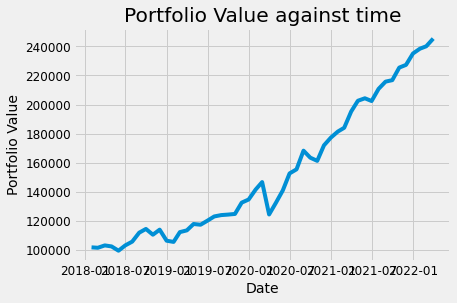

In [15]:
cumulativeChange = 1* 100000
portfolioValuesArr = []
for i in portfolioChangesArr[1:]:
    cumulativeChange *= 1 + (i/100)
    portfolioValuesArr.append(cumulativeChange)
    
y = portfolioValuesArr 
x = portfolioRatio.index[1:]

plt.title('Portfolio Value against time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.plot(x,y)

In [19]:
portfolioValueChange = []
allPortfolioValues = [100000, *portfolioValuesArr]

for i, value in enumerate(allPortfolioValues):
    if i==0:
        continue
    change = (value-allPortfolioValues[i-1])/allPortfolioValues[i-1]
    portfolioValueChange.append(change)

In [20]:
import utils.sharpeCalculation as sharpeCalculation
sharpeRatio = sharpeCalculation.sharpe_ratio(portfolioValueChange)
finalPortfolioValue = portfolioValuesArr[-1]

print(f"Final Portfolio Value: ${round(finalPortfolioValue, 2)}")
print("Sharpe Ratio:", round(sharpeRatio, 2))
print("Percentage Return: " + str(round((finalPortfolioValue-100000)*100/100000, 2)) + "%")

Final Portfolio Value: $245334.21
Sharpe Ratio: 3.34
Percentage Return: 145.33%
